In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Generate X
X = torch.rand(500, 2)
# Define a function to calculate y based on X
def calculate_y(X):
    # Example dependency: y = 2 * X[:, 0] + 3 * X[:, 1] + some_noise
    y = 2 * X[:, 0] + 3 * X[:, 1]
    #add noise using normal distribution with mean 0 and std 0.1
    y += torch.normal(0, 0.1, size=y.shape)
    return y.reshape(-1, 1)  # Reshape to match the desired shape of y


# Calculate y based on X
y = calculate_y(X)
print(X.shape)
print(y.shape)

torch.Size([500, 2])
torch.Size([500, 1])


In [3]:
split = int(0.8*len(X))
X_train, X_test = X[:split],X[split:]
y_train, y_test = y[:split],y[split:]
X_train.shape, y_train.shape

(torch.Size([400, 2]), torch.Size([400, 1]))

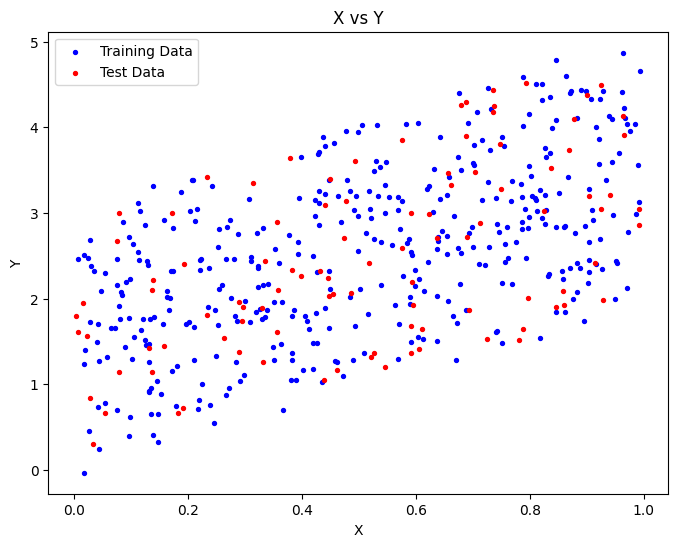

In [4]:

def plot_data(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, predictions=None):
    plt.figure(figsize=(8, 6))


    plt.scatter(X_train[:,0], y_train, c='b', s=8, label='Training Data')
    plt.scatter(X_test[:,0], y_test, c='r', s=8, label='Test Data')

    if predictions is not None:
        plt.scatter(X_test[:,0], predictions,
                    c='g', label='Predicted Data')

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("X vs Y")
    plt.show()
plot_data()

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_features=2):
        super().__init__()
        self.layer1 = nn.Linear(in_features = input_features,out_features = hidden_features)
        self.layer2 = nn.Linear(in_features=hidden_features,out_features = output_features)
        self.activation = nn.ReLU()

    def forward(self, x):
        h = self.activation(self.layer1(x))
        y_out = self.layer2(h)
        return y_out

In [6]:
torch.manual_seed(42)
model_1 = NeuralNetwork(input_features=2, output_features=1)


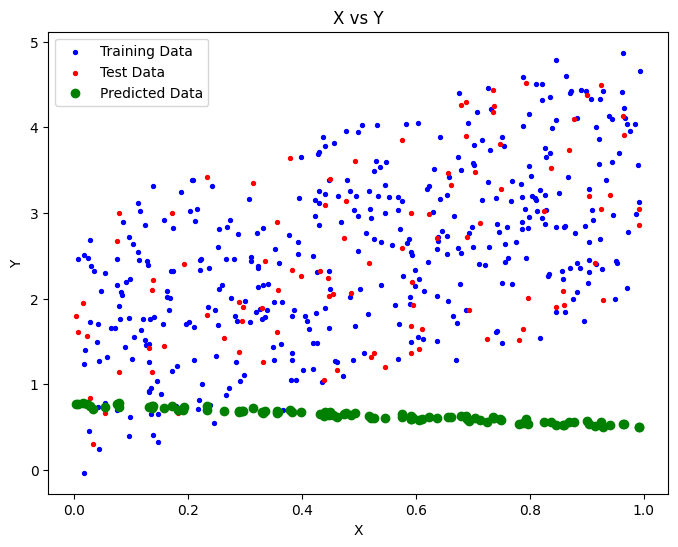

In [7]:
# Get the predictions switch the model to inference mode
with torch.inference_mode():
    y_preds = model_1(X_test)
plot_data(predictions=y_preds)

In [8]:
def calculate_accuracy(y_true, y_pred, threshold=0.1):
  """Calculates accuracy based on a threshold.

  Args:
    y_true: The true target values.
    y_pred: The predicted target values.
    threshold: The threshold within which predictions are considered accurate.

  Returns:
    The accuracy as a float between 0 and 1.
  """
  # Calculate absolute differences between true and predicted values
  absolute_diff = torch.abs(y_true - y_pred)

  # Check if absolute differences are within the threshold
  correct_predictions = absolute_diff <= threshold

  # Calculate the accuracy
  accuracy = correct_predictions.sum().item() / len(y_true)
  return accuracy*100

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [10]:
#training loop
epochs = 3000
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    train_pred = model_1.forward(X_train)

    #loss calculation
    train_loss = loss_fn(train_pred, y_train)

    # Zero grad optimizer
    optimizer.zero_grad()

    # Back Propagation
    train_loss.backward()

    # step the optimizer
    optimizer.step()

    train_accuracy = calculate_accuracy(y_train, train_pred)


    # testing
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(y_test, test_pred)

    test_accuracy = calculate_accuracy(y_test, test_pred)

    if epoch % 10 == 0:
      print(
            f"Epoch:{epoch}|Train Loss:{train_loss:.5f}|Test Loss:{test_loss:.5f}|Train Acc:{train_accuracy}|Test Acc:{test_accuracy}")

    trainLossList.append(train_loss.item())
    testLossList.append(test_loss.item())


Epoch:0|Train Loss:4.61058|Test Loss:4.20044|Train Acc:2.5|Test Acc:3.0
Epoch:10|Train Loss:2.46654|Test Loss:2.25626|Train Acc:4.25|Test Acc:4.0
Epoch:20|Train Loss:1.29452|Test Loss:1.21013|Train Acc:7.249999999999999|Test Acc:10.0
Epoch:30|Train Loss:0.77677|Test Loss:0.76807|Train Acc:8.0|Test Acc:13.0
Epoch:40|Train Loss:0.60468|Test Loss:0.62713|Train Acc:7.5|Test Acc:8.0
Epoch:50|Train Loss:0.54941|Test Loss:0.58112|Train Acc:9.0|Test Acc:3.0
Epoch:60|Train Loss:0.52253|Test Loss:0.55611|Train Acc:12.5|Test Acc:6.0
Epoch:70|Train Loss:0.50149|Test Loss:0.53472|Train Acc:13.0|Test Acc:5.0
Epoch:80|Train Loss:0.48172|Test Loss:0.51390|Train Acc:12.75|Test Acc:6.0
Epoch:90|Train Loss:0.46238|Test Loss:0.49327|Train Acc:13.0|Test Acc:6.0
Epoch:100|Train Loss:0.44333|Test Loss:0.47285|Train Acc:13.5|Test Acc:6.0
Epoch:110|Train Loss:0.42455|Test Loss:0.45269|Train Acc:13.25|Test Acc:6.0
Epoch:120|Train Loss:0.40605|Test Loss:0.43282|Train Acc:14.000000000000002|Test Acc:6.0
Epoch:130

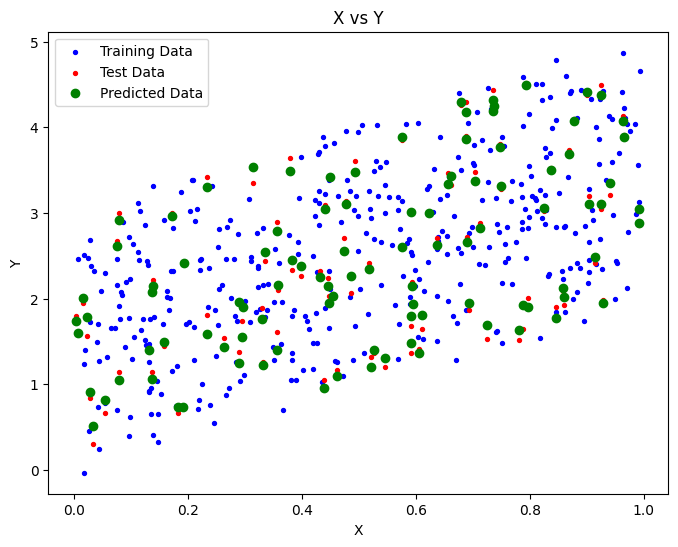

In [11]:
with torch.inference_mode():
    y_preds = model_1(X_test)

plot_data(predictions=y_preds)

In [12]:
# Print all weights and biases
print("Model Weights and Biases:")
for name, param in model_1.state_dict().items():
    print(f"{name}: {param}")

Model Weights and Biases:
layer1.weight: tensor([[0.6644, 0.6364],
        [0.9563, 1.5086]])
layer1.bias: tensor([-0.2454, -0.2134])
layer2.weight: tensor([[0.6056, 1.7131]])
layer2.bias: tensor([0.5098])


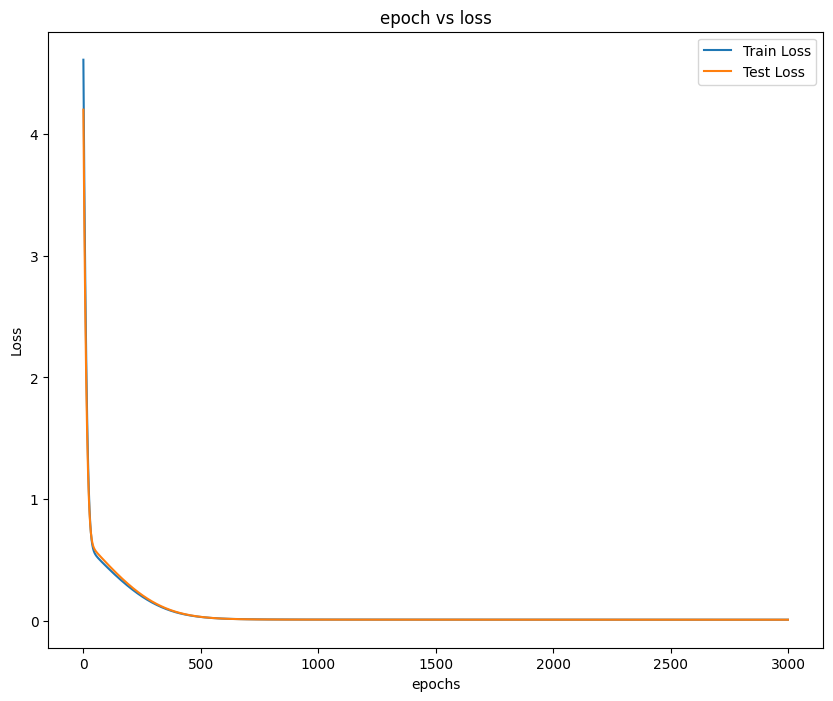

In [13]:
# plot loss curve
plt.figure(figsize=(10, 8))
plt.plot(range(epochs), trainLossList, label='Train Loss')
plt.plot(range(epochs), testLossList, label='Test Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("epoch vs loss")
plt.legend()
plt.show()